In [1]:


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.optimize as spo
from tqdm import tqdm


[7.24399826e-05]


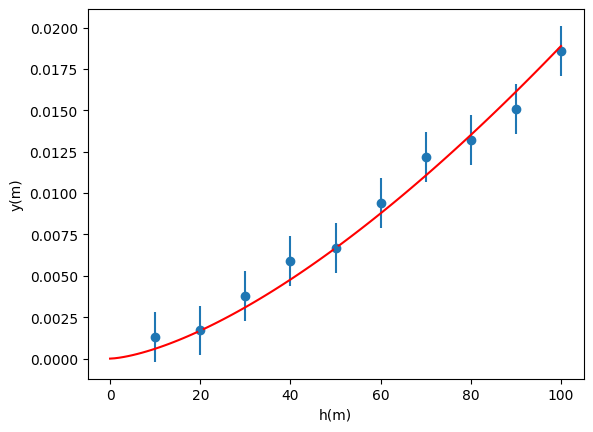

In [2]:
###A
url ="https://raw.githubusercontent.com/asegura4488/Database/main/MetodosComputacionalesReforma/DataRotacion.csv"
###B
Data = pd.read_csv(url,sep=",",engine='python')



sigmay=np.array(Data.sigmay,np.float64)

Data_30=Data.query("angle==30")

###C

def Model(p,h,latitude,g):
    
    return (2*np.sqrt(2)/3)*p*np.cos(latitude*np.pi/180)*np.sqrt(h**3/g)


###D

def Chi_2(p,h,y,sigmay,angle,g):
    
    return np.sum(((y-Model(p[0],h,angle,g))**2/sigmay**2))

###E

g0=9.81
p0=[0.]
args=(Data_30.h,Data_30.y,Data_30.sigmay,Data_30.angle,g0)
Min_=spo.minimize(Chi_2,p0,args=args)
Omega_30=Min_.x
print(Omega_30)


####F

fig1=plt.figure()
ax=fig1.add_subplot()
ax.scatter(Data_30.h,Data_30.y)
ax.errorbar(Data_30.h,Data_30.y,yerr=Data_30.sigmay,fmt=".")
ax.set_xlabel("h(m)")
ax.set_ylabel("y(m)")
x_=np.linspace(0,100,100)
y_=Model(Omega_30,x_,30.,9.81)

plt.plot(x_,y_,color="r")


###Propagación de la incertidumbre de la aceleración de la gravedad

100%|██████████| 300/300 [00:33<00:00,  9.02it/s]


7.23290522950004e-05 [6.249907840271071e-05, 8.35900025692685e-05]


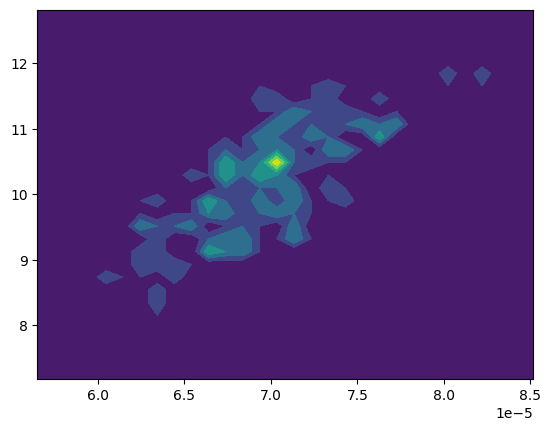

In [4]:
####A

N=300
Gravedad=np.zeros(N)
Omega=np.zeros(N)
y=Data_30.y

for i in tqdm(range(N)):
    Gravedad[i]=9.81 + np.random.normal(loc=0,scale=1)
    
    yi=y + np.random.normal( loc=0, scale=sigmay[0], size=len(y) )
    
    Omega[i]=spo.minimize(Chi_2,p0,args=(Data_30.h,yi,Data_30.sigmay,Data_30.angle,Gravedad[i])).x
    
H2,binsx,binsy = np.histogram2d(Omega,Gravedad,bins=(30,30))


fig2=plt.figure()
ax2=fig2.add_subplot()
ax2.contourf(binsx[0:-1],binsy[0:-1],H2)

H1 = np.sum(H2,axis=1)

cs = np.cumsum(H1)
ij = np.searchsorted( cs, np.percentile(cs,16) )
ii = np.searchsorted( cs, np.percentile(cs,50) )
ji = np.searchsorted( cs, np.percentile(cs,84) )

Omega_sort=np.sort(Omega)

omega_best=Omega_sort[int(cs[ii])]
CL=[Omega_sort[int(cs[ij])],Omega_sort[int(cs[ji])]]

print(omega_best,CL)


-Las variables estan correlacionadas positivamente.

In [5]:
def Resample(Data_):
    
    N=300
    Gravedad=np.zeros(N)
    Omega=np.zeros(N)
    y=Data_.y

    for i in tqdm(range(N)):
        Gravedad[i]=9.81 + np.random.normal(loc=0,scale=1)
        
        yi=y + np.random.normal( loc=0, scale=sigmay[0], size=len(y) )
        
        Omega[i]=spo.minimize(Chi_2,p0,args=(Data_.h,yi,Data_.sigmay,Data_.angle,Gravedad[i])).x
        
    H2,binsx,binsy = np.histogram2d(Omega,Gravedad,bins=(300,300))


    

    H1 = np.sum(H2,axis=1)

    cs = np.cumsum(H1)
    ij = np.searchsorted( cs, np.percentile(cs,16) )
    ii = np.searchsorted( cs, np.percentile(cs,50) )
    ji = np.searchsorted( cs, np.percentile(cs,84) )

    Omega_sort=np.sort(Omega)

    omega_best=Omega_sort[int(cs[ii])]
    CL=[Omega_sort[int(cs[ij])],Omega_sort[int(cs[ji])]]
    sigma=(CL[1]-CL[0])/2
    
    return omega_best,CL,sigma/omega_best


Omegas=np.zeros((7,3))

for i in range(1,7):
    Angle=i*10
    w=Resample(Data.query("angle==@Angle"))
    Omegas[i-1,0]=Angle
    Omegas[i-1,1]=w[0]*1e5
    Omegas[i-1,2]=w[2]

Omegas[6,0]=70
wc=Resample(Data)
Omegas[6,1]=wc[0]*1e5
Omegas[6,2]=wc[2]

Omegas

100%|██████████| 300/300 [00:33<00:00,  8.86it/s]


array([[10.        ,  7.13841504,  0.11552989],
       [20.        ,  7.24618344,  0.12983918],
       [30.        ,  7.14677337,  0.11121663],
       [40.        ,  7.41960859,  0.13235086],
       [50.        ,  6.7608732 ,  0.15296991],
       [60.        ,  7.52901022,  0.1557045 ],
       [70.        ,  7.02275204,  0.11179724]])

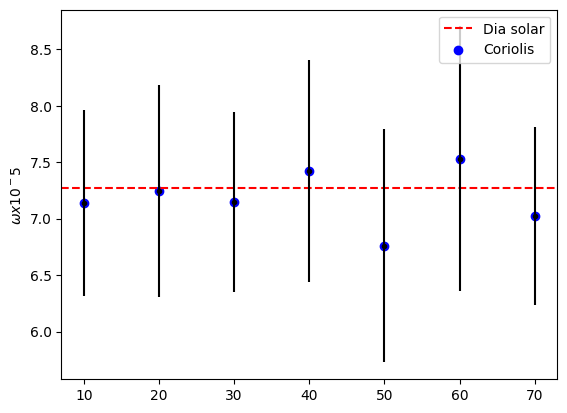

In [10]:
fig3=plt.figure()
ax3=fig3.add_subplot()
ax3.axhline(y=7.27,ls="--",color="r",label="Dia solar")
ax3.errorbar(Omegas[:,0],Omegas[:,1],yerr=Omegas[:,2]*Omegas[:,1],fmt=".",color="k")
ax3.scatter(Omegas[:,0],Omegas[:,1],color="b",label="Coriolis")
ax3.set_ylabel("$\omega x 10^-5$")
ax3.legend()